### Исследование юнит-экономики мобильной игры

**Бизнес-контекст**

Вы продолжите работать с однопользовательской игрой Mines & Moles. Однако расчёты в этом проекте будут касаться только мира юнит-экономики и привлечения клиентов, а эти механизмы похожи у многих приложений, будь то агрегатор такси или мобильная игра.
Во многом благодаря удачным решениям отдела аналитики за последний год мобильная игра не только не обанкротилась, но и успешно развивалась, привлекая новых пользователей. Метрики продукта в целом стабильны и не вызывают опасений.
Но, как говорил один известный персонаж, чтобы оставаться на месте, нужно бежать со всех ног. И в такой быстро развивающейся сфере, как мобильные игры, никогда нельзя останавливаться на достигнутом. Для развития приложению постоянно требуются новые источники трафика, и менеджеры просят вас проанализировать экономику текущих способов привлечения и приготовить экспертное заключение.

Общая задача:  
Провести расчёт и анализ ключевых метрик: LTV, CAC, ROI, ARPPU и Retention Rate — и составить заключение о текущем состоянии юнит-экономики приложения.

В рамках решения этой задачи вы подготовите данные, проведёте когортный анализ ключевых финансовых метрик и оцените окупаемость.  

**План работы:**
- Подготовка данных.
- Когортный анализ LTV.
- Расчёт CAC.
- Расчёт Payback Period.
- Расчёт ROI.
- Расчёт ARPPU и Retention Rate.

## 1. Подготовка данных

- Выполним загрузку файлов и предобработку данных в таблицах.

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [7]:
path_users = 'https://code.s3.yandex.net/datasets/mm_game_users.csv'
path_events = 'https://code.s3.yandex.net/datasets/mm_game_events.csv'
path_transactions = 'https://code.s3.yandex.net/datasets/mm_game_transactions.csv'

In [8]:
# Создаём датафреймы для трёх таблиц
df_users = pd.read_csv(path_users)
df_events = pd.read_csv(path_events)
df_transactions = pd.read_csv(path_transactions)

In [9]:
# Выводим на экран размер исходных таблиц
print(df_users.shape, df_events.shape, df_transactions.shape)

(23218, 8) (1154105, 4) (73480, 8)


- Для расчёта и визуализации метрик будем агрегировать данные в таблицах с событиями и транзакциями по месяцам.

In [11]:
# Преобразуем время события в формат месяца Period[M] для анализа данных по месяцам
df_events['time'] = pd.to_datetime(df_events['time'])
df_events['activity_month'] = df_events['time'].dt.to_period('M')

In [12]:
# Определяем первый месяц активности для каждого устройства  
df_events['first_activity_month'] = df_events.groupby('device_id')['activity_month'].transform('min')

In [13]:
# Группируем по устройству, месяцу, первому месяцу активности и подсчитываем сессии
df_monthly_events = df_events.groupby(['device_id', 'activity_month', 'first_activity_month'])['session_id'].count().reset_index()

- Рассчитаем месячную выручку

In [15]:
# Преобразование колонки 'time' в формат Period[M] для анализа данных на месячном уровне
df_transactions['time'] = pd.to_datetime(df_transactions['time'])
df_transactions['activity_month'] = df_transactions['time'].dt.to_period('M')

In [16]:
# Фильтрация успешных транзакций — это исключает отменённые/незавершённые платежи
df_successful_transactions = df_transactions[df_transactions['status'] == 'success']

In [17]:
# Группировка данных по устройству и месяцу с расчётом общей выручки пользователей за каждый месяц
df_monthly_transactions = df_successful_transactions.groupby(['device_id', 'activity_month'], as_index=False)['price'].sum()

In [18]:
# Для колонки с суммарной выручкой устанавливаем название total_revenue
df_monthly_transactions = df_monthly_transactions.rename(columns={'price': 'total_revenue'})

- Создадим датафрейм  для анализа

In [20]:
# Объединяем данные о событиях и транзакциях по device_id и месяцу активности
df_monthly_events_transactions = pd.merge(df_monthly_events, df_monthly_transactions, how = 'left', on = ['device_id', 'activity_month'])

In [21]:
# Заполняем пропуски нулём
df_monthly_events_transactions.fillna(0, inplace = True)

In [22]:
# Объединяем данные о событиях и транзакциях с атрибутами пользователей из таблицы df_users
df_monthly = pd.merge(
    df_monthly_events_transactions, df_users[['device_id', 'traffic_type', 'source']], how = 'left', on = 'device_id')

In [23]:
# Рассчитываем, сколько месяцев прошло с первого месяца активности пользователя до текущего месяца
df_monthly['n_period'] = df_monthly['activity_month'].dt.month - df_monthly['first_activity_month'].dt.month

In [24]:
# Удаляем данные за последний доступный месяц, так как они могут быть неполными
df_monthly = df_monthly[df_monthly['n_period'] != 0]

## 2. Когортный анализ LTV

- Рассчитаем накопленный Lifetime Value (LTV) пользователей.

In [27]:
# Сортируем значения для корректного расчёта кумулятивной суммы
df_monthly = df_monthly.sort_values(by=['device_id', 'traffic_type', 'n_period'])

In [28]:
# Рассчитываем LTV как кумулятивную сумму выручки одного пользователя
df_monthly['LTV'] = df_monthly.groupby(['device_id'])['total_revenue'].cumsum()

In [29]:
# Для каждой когорты, периода и источника трафика рассчитываем среднее значение LTV
df_grouped_ltv = df_monthly.groupby(['first_activity_month', 'n_period', 'traffic_type'])['LTV'].mean().reset_index()

In [30]:
df_grouped_ltv.head()

,first_activity_month,n_period,traffic_type,LTV
0,2024-01,1,organic,16.340483
1,2024-01,1,paid,14.060241
2,2024-01,1,referral,9.361345
3,2024-01,2,organic,31.014337
4,2024-01,2,paid,27.126551


- Проведем анализ среднего LTV пользователей из разных когорт в разрезе источников трафика

In [32]:
df_grouped_ltv = pd.read_csv('https://code.s3.yandex.net/datasets/mm_grouped_ltv.csv')

In [33]:
# Устанавливаем размер графика
plt.rcParams['figure.figsize'] = (10, 3)

In [34]:
# Определяем список когорт (первых месяцев активности) для анализа
first_activity_months = ['2024-01', '2024-04', '2024-06', '2024-09']

In [35]:
# Фильтруем данные, оставляя только интересующие нас когорты
df_plot = df_grouped_ltv[df_grouped_ltv['first_activity_month'].isin(first_activity_months)]

In [36]:
traffic_sources = ['organic', 'referral', 'paid']

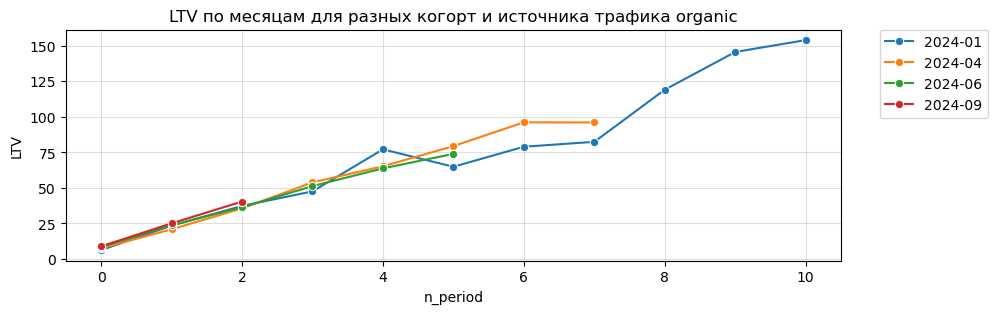

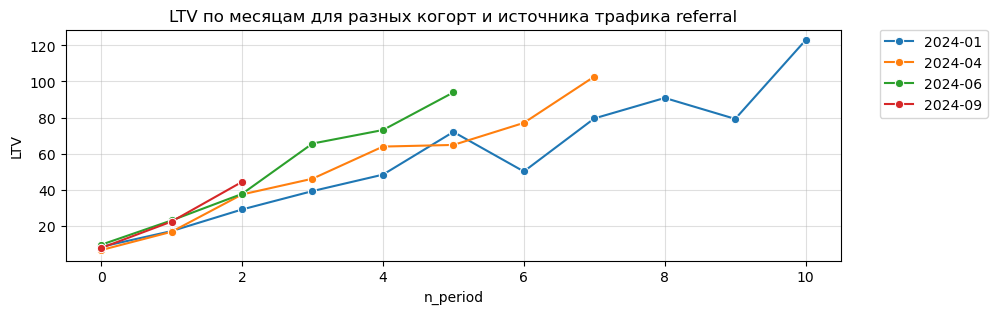

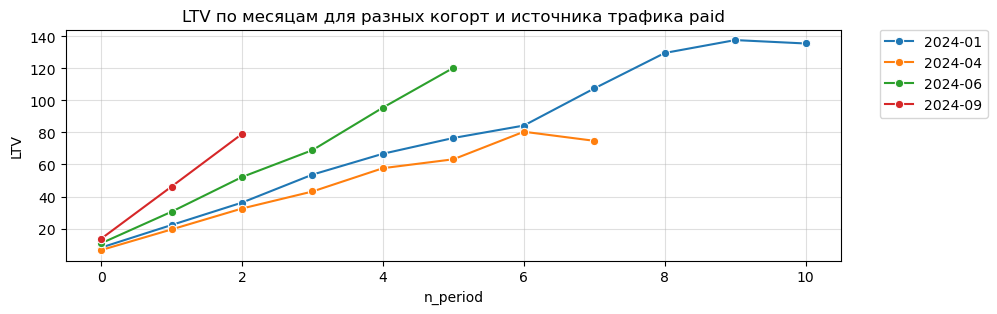

In [37]:
# Строим графики для каждого из трёх источников трафика в цикле
for traffic_source in traffic_sources:
    # Фильтруем данные: только для текущего источника трафика
    filtered_data = df_plot[df_plot['traffic_type'] == traffic_source]
    # Строим линейный график с маркерами
    sns.lineplot(
    data=filtered_data,
    x='n_period',
    y='LTV',
    hue='first_activity_month',
    marker='o'
    )
    # Задаём дополнительные параметры для лучшего отображения графиков
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(f'LTV по месяцам для разных когорт и источника трафика {traffic_source}')
    plt.xlabel('n_period')
    plt.ylabel('LTV')
    plt.grid(alpha=.4)
    plt.show()

- Визуализируем динамику LTV в разрезе двух источников трафика - 'referral' и 'paid'. Создадим тепловые карты для анализа динами LTV пользователей из разных когорт

In [39]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

In [40]:
# Устанавливаем размер графика
plt.rcParams['figure.figsize'] = (12, 6)

In [41]:
# Создаём pivot-таблицы для визуализации LTV по типам трафика
# referral-трафик: преобразуем данные в форму 'когорта x период' с заменой нулей на NaN (для наглядности)
df_pivot_referral = df_grouped_ltv[df_grouped_ltv['traffic_type'] == 'referral'].pivot(index = 'first_activity_month', columns = 'n_period', values = 'LTV')
df_pivot_referral[df_pivot_referral == 0] = float('nan')
# paid-трафик: преобразуем данные в форму 'когорта x период' с заменой нулей на NaN (для наглядности)
df_pivot_paid = df_grouped_ltv[df_grouped_ltv['traffic_type'] == 'paid'].pivot(index = 'first_activity_month', columns = 'n_period', values = 'LTV')
df_pivot_paid[df_pivot_paid == 0] = float('nan')

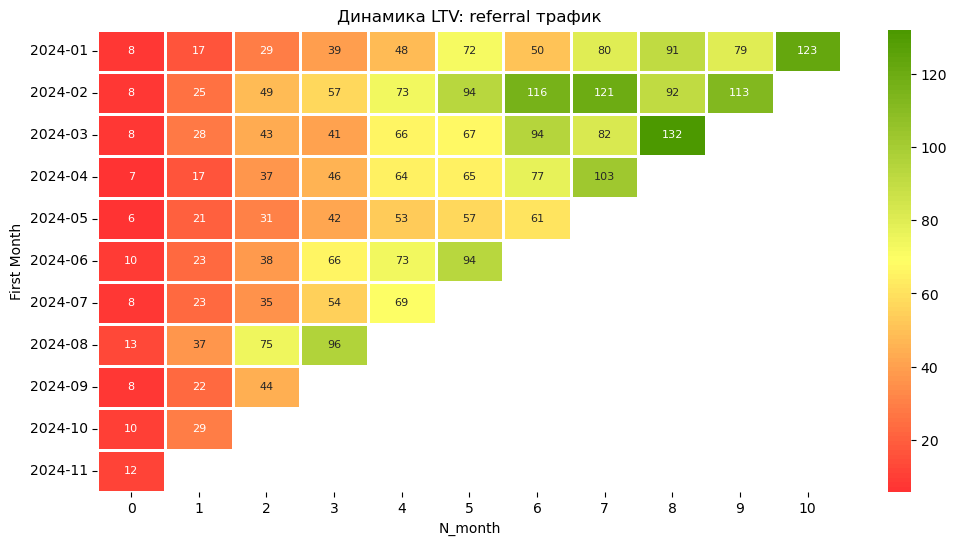

In [42]:
# Строим тепловую карту для трафика referral
sns.heatmap(df_pivot_referral,
           cmap=cmap,
           annot=True,
           fmt='.0f',
           linewidths=2,
           annot_kws={"size": 8})

# Добавляем подписи для осей и заголовок графика referral
plt.title('Динамика LTV: referral трафик')
plt.xlabel('N_month')
plt.ylabel('First Month')
plt.show()

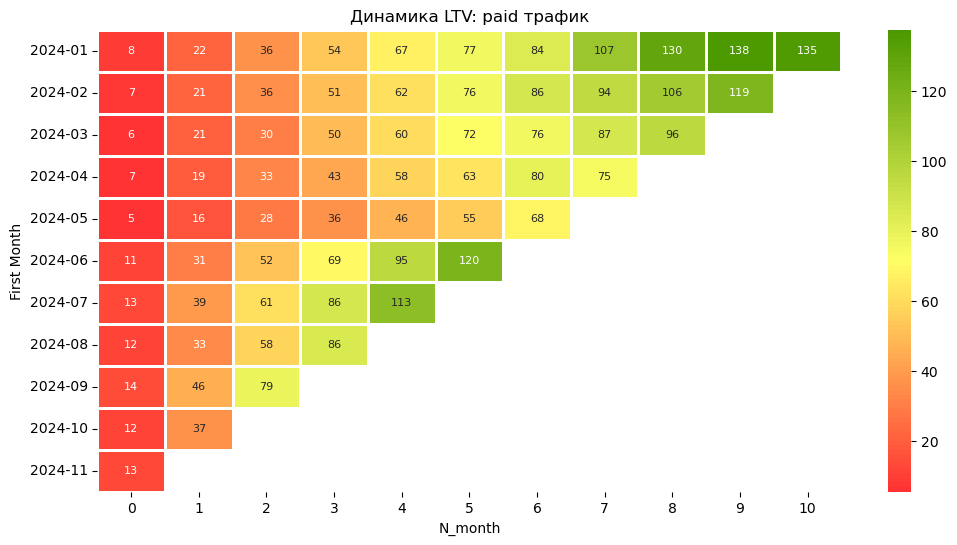

In [43]:
# Строим тепловую карту для трафика paid
sns.heatmap(df_pivot_paid,
           cmap=cmap,
           annot=True,
           fmt='.0f',
           linewidths=2,
           annot_kws={"size": 8})

# Добавляем подписи для осей и заголовок графика paid
plt.title('Динамика LTV: paid трафик')
plt.xlabel('N_month')
plt.ylabel('First Month')
plt.show()

**Интерпретация LTV**

- Органический трафик демонстрирует стабильный LTV без существенных изменений в динамике.
- Для реферального трафика заметны небольшие различия в динамике LTV между когортами первой и второй половины года.
- Платный трафик показывает наиболее выраженный рост LTV: когорты второй половины года значительно опережают показатели первой половины.

## 3. Расчет CAC

- Построим график динамики маркетинговых затрат в разрезе источников трафика за период, представленный в данных

In [47]:
# Загружаем файл и создаём датафрейм с маркетинговыми затратами
path_marketing = 'https://code.s3.yandex.net/datasets/mm_game_marketing_costs.csv'
df_marketing_costs = pd.read_csv(path_marketing)
df_marketing_costs['first_activity_month']  = pd.to_datetime(df_marketing_costs['month']).dt.to_period('M')

In [48]:
# Инициализируем фигуру
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

C:\Users\maria\AppData\Local\Temp\ipykernel_30948\4072748116.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(


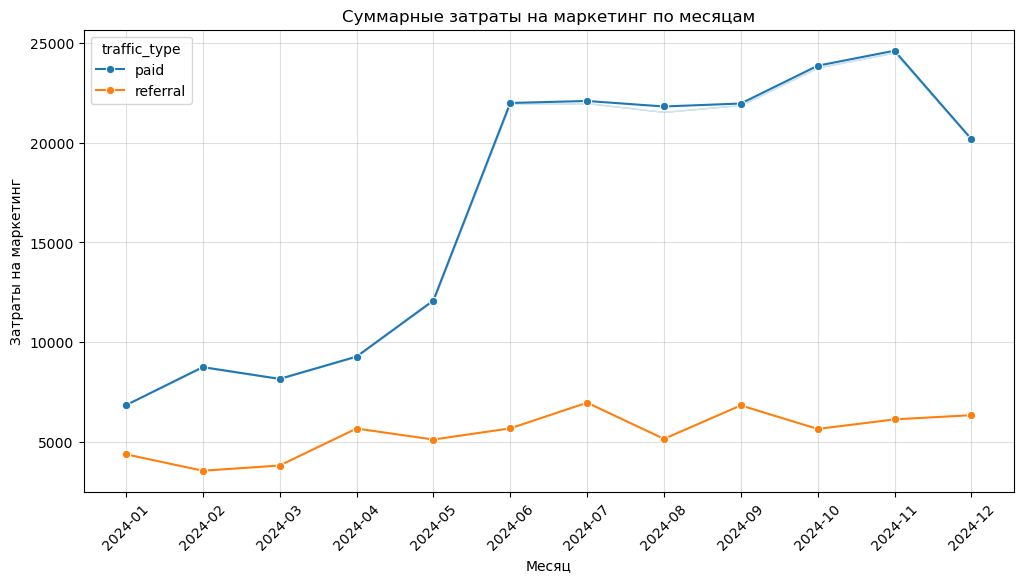

In [49]:
# Строим линейный график маркетинговых затрат для каждого типа трафика
sns.lineplot(
    data=df_marketing_costs,
    x='month',
    y='marketing_costs',
    hue='traffic_type',
    ci=False,
    marker='o',
)
plt.grid(alpha=.4)
plt.xticks(rotation=45)
plt.xlabel('Месяц')
plt.ylabel('Затраты на маркетинг')
plt.title('Суммарные затраты на маркетинг по месяцам')
plt.show()

- Рассчитаем стоимость привлечения одного клиента

In [51]:
# Определяем колонки для группировки: когорта, источник и тип трафика
gp_cols = ['first_activity_month', 'source', 'traffic_type']

In [52]:
# Считаем количество уникальных устройств (пользователей) для каждой комбинации: когорта + источник + тип трафика
df_clients_count = df_monthly.groupby(gp_cols)['device_id'].nunique().reset_index()

In [53]:
# Объединяем данные о маркетинговых затратах с количеством пользователей
df_CAC = pd.merge(df_marketing_costs, df_clients_count, how = 'left', on = gp_cols)

In [54]:
# Рассчитываем стоимость привлечения клиента по формуле: CAC = расходы на маркетинг / количество привлечённых пользователей
df_CAC['CAC'] = df_CAC['marketing_costs']/df_CAC['device_id']

In [55]:
# Добавляем колонку CAC в основной датафрейм
df_monthly = pd.merge(
    df_monthly,
    df_CAC[['first_activity_month', 'source', 'traffic_type', 'CAC']], how = 'left', on = gp_cols)

In [56]:
df_monthly.head()

,device_id,activity_month,first_activity_month,session_id,total_revenue,traffic_type,source,n_period,LTV,CAC
0,0000614f-d87f-4b5b-a082-d86e72c22696,2024-08,2024-07,5,0.0,paid,google,1,0.0,76.23750
1,0000614f-d87f-4b5b-a082-d86e72c22696,2024-11,2024-07,4,0.0,paid,google,4,0.0,76.23750
2,0000614f-d87f-4b5b-a082-d86e72c22696,2024-12,2024-07,18,25.0,paid,google,5,25.0,76.23750
3,00010045-a5c6-4428-a40e-543f6a00c779,2024-10,2024-09,13,64.0,paid,tiktok,1,64.0,286.94362
4,00010045-a5c6-4428-a40e-543f6a00c779,2024-11,2024-09,13,0.0,paid,tiktok,2,64.0,286.94362


- Отобразим динамику средней стоимости привлечения клиента по типам трафика в разрезе месяцев

In [62]:
df_monthly = pd.read_csv('https://code.s3.yandex.net/datasets/mm_monthly_ltv_cac.csv')

In [63]:
# Группируем данные по когорте (месяц первой активности) и типу трафика — рассчитываем средний CAC для каждой группы
cac_grouped = df_monthly.groupby(['first_activity_month', 'traffic_type'])['CAC'].mean().reset_index()

In [64]:
cac_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   first_activity_month  33 non-null     object 
 1   traffic_type          33 non-null     object 
 2   CAC                   22 non-null     float64
dtypes: float64(1), object(2)
memory usage: 924.0+ bytes


In [68]:
# Инициализируем холст для графика
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

C:\Users\maria\AppData\Local\Temp\ipykernel_30948\945683259.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(


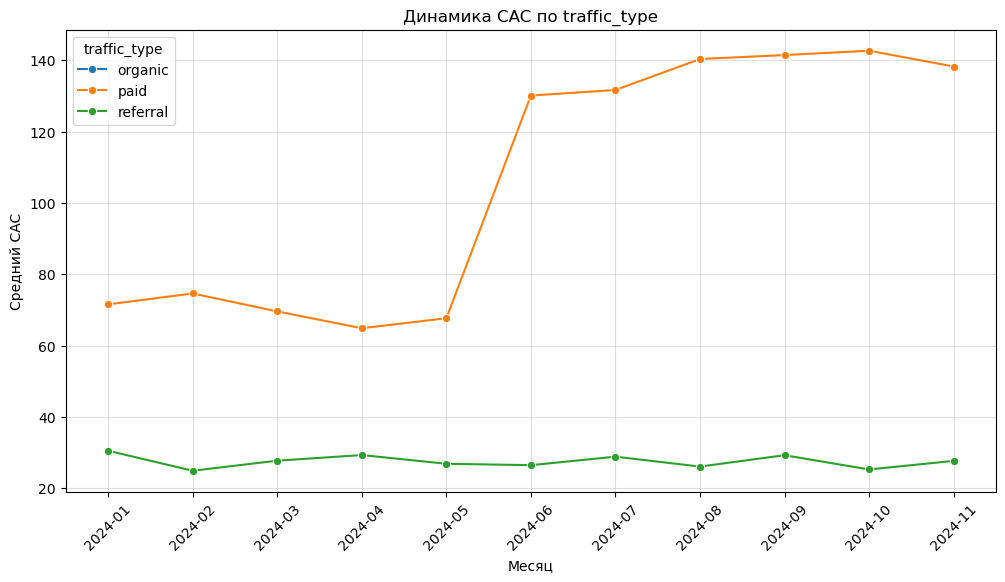

In [70]:
# Строим линейный график с разделением по типам трафика
sns.lineplot(
    data=cac_grouped,
    x='first_activity_month',
    y='CAC',
    hue='traffic_type',
    ci=False,
    marker='o'
)
plt.xticks(rotation=45)
plt.grid(alpha=.4)
plt.xlabel('Месяц')
plt.ylabel('Средний CAC')
plt.title('Динамика CAC по traffic_type')
plt.show()

**Интерпретация LTV и CAC**

- Начиная с июня суммарные маркетинговые затраты для привлечения пользователей из платного трафика выросли примерно в полтора-два раза относительно первой половины года.
- Стоимость привлечения пользователей для реферального трафика оставалась стабильной в течение года.
- Со второй половины года стоимость привлечения пользователя из платного трафика выросла более чем в полтора раза — аналогично суммарным маркетинговым затратам.

## 4. Расчет Payback Period

- Создадим вспомогательный датафрейм 'cac_ltv_grouped'. В нем проведем предварительную фильтрацию и агрегацию данных, рассчитав средние значения LTV и CAC для каждой когорты платного трафика.

In [76]:
# Из основной таблицы выберем только значения для платного трафика
df_monthly_paid = df_monthly[df_monthly['traffic_type'] == 'paid']

In [78]:
# Для каждой когорты и канала посчитаем среднее значение LTV, CAC
cac_ltv_grouped = df_monthly_paid.groupby(['first_activity_month', 'n_period']).agg({'LTV':'mean', 'CAC':'mean'}).reset_index()

- Визуализируем среднее LTV и CAC по когортам

In [87]:
cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')

In [89]:
# Словарь с когортами и соответствующими им цветами
first_months_colors = {'2024-01-01': 'blue', '2024-03-01': 'red', '2024-06-01': 'green', '2024-08-01': 'purple'}
# Создаём график
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

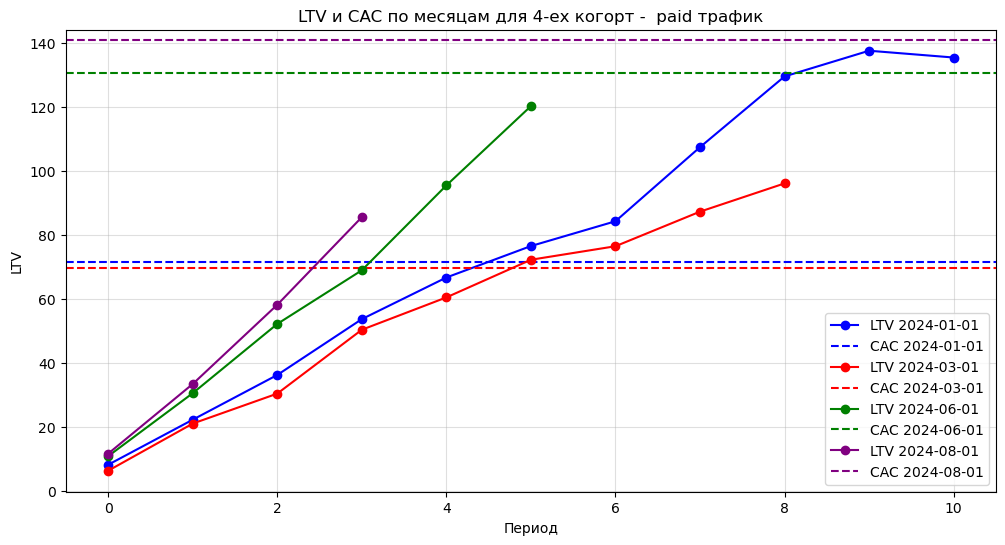

In [91]:
# Строим линии для каждого first_activity_month (когорты)
for month, color in first_months_colors.items():
    # Создаём отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month'] == month]
    # Строим LTV с цветом из словаря
    plt.plot(
        df_plot['n_period'],
        df_plot['LTV'],
        color=color,
        marker='o',
        label=f'LTV {month}'
    )
    # Строим линию для CAC с тем же цветом
    cac_value = df_plot['CAC'].mean()
    plt.axhline(
        y=cac_value,
        color=color,
        linestyle='--',
        label=f'CAC {month}'
    )
plt.title('LTV и CAC по месяцам для 4-ех когорт -  paid трафик')
plt.xlabel('Период')
plt.ylabel('LTV')
plt.legend()
plt.grid(alpha=.4)
plt.show()

**Интерпретация Payback Period**
- Для когорт второй половины года наблюдается ускоренный рост LTV, при этом значительно вырос CAC.
- Срок окупаемости мартовской когорты немного выше, чем у январской.
- Если мысленно продлить линии LTV, то отличия в Payback Period у когорт первой и второй половины года окажутся довольно незначительными и, скорее всего, не превысят одного месяца.

## 5. Расчет ROI

- Визуализируем динамику ROI для выбранных когорт пользователей и границу окупаемости затрат

In [96]:
cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')

In [98]:
# Словарь с когортами и соответствующими им цветами
first_months_colors = {'2024-01-01': 'blue', '2024-03-01': 'red', '2024-06-01': 'green', '2024-08-01': 'purple'}

In [100]:
# Рассчитываем ROI для каждой когорты и периода
cac_ltv_grouped['ROI'] = (cac_ltv_grouped['LTV'] - cac_ltv_grouped['CAC']) / cac_ltv_grouped['CAC'] * 100

In [102]:
# Создаём график
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

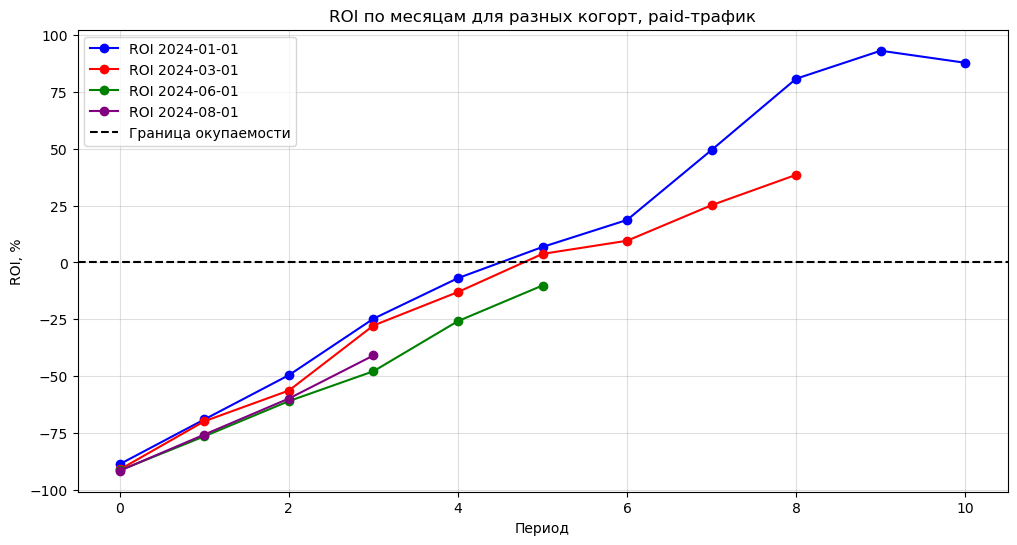

In [104]:
# Строим линии для каждого first_activity_month (когорты)
for month, color in first_months_colors.items():
    # Создаём промежуточный отфильтрованный датафрейм для текущей когорты
    df_plot = cac_ltv_grouped[cac_ltv_grouped['first_activity_month'] == month]

    # Строим динамику ROI по периодам с цветами из словаря
    plt.plot(
        df_plot['n_period'],
        df_plot['ROI'],
        color=color,
        marker='o',
        label=f'ROI {month}'
    )
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
plt.title('ROI по месяцам для разных когорт, paid-трафик')
plt.xlabel('Период')
plt.ylabel('ROI, %')
plt.legend()
plt.grid(alpha=.4)
plt.show()

- Визуализируем ROI в виде тепловой карты

In [107]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

In [109]:
cac_ltv_grouped = pd.read_csv('https://code.s3.yandex.net/datasets/mm_cac_ltv_grouped.csv')
cac_ltv_grouped['first_activity_month'] = pd.to_datetime(cac_ltv_grouped['first_activity_month']).dt.to_period('M')

In [111]:
df_pivot_ltv = cac_ltv_grouped.pivot(index='first_activity_month', columns='n_period', values='LTV')

In [113]:
# pivot для CAC
df_pivot_cac = cac_ltv_grouped.pivot(index='first_activity_month', columns='n_period', values='CAC')

In [115]:
# Расчёт матрицы ROI на основе пивотированных таблиц LTV и CAC
df_pivot_roi = (df_pivot_ltv - df_pivot_cac) / df_pivot_cac * 100

In [117]:
# Заменяем нули в df_pivot_roi на NaN для корректной отрисовки
df_pivot_roi[df_pivot_roi == 0] = float('nan')

In [119]:
# Создаём график
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

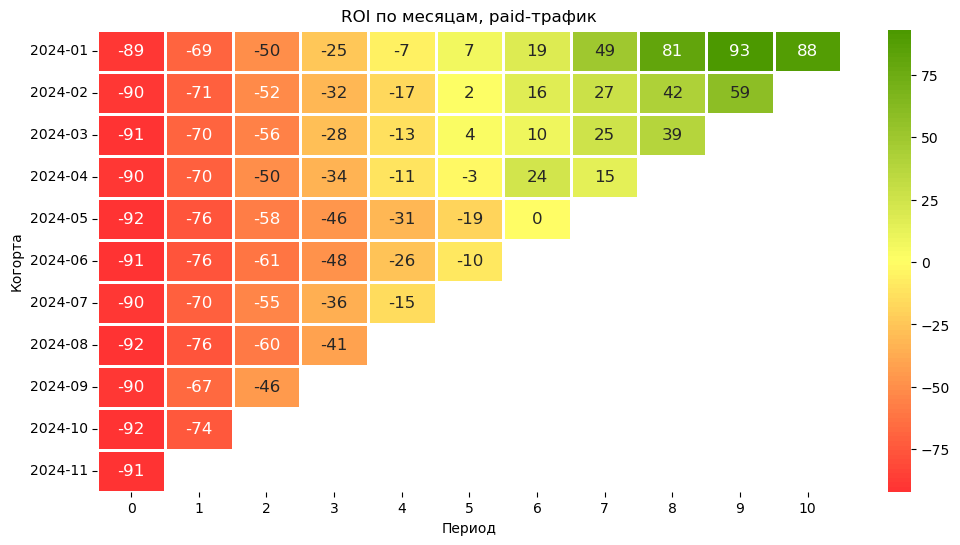

In [121]:
# Строим heatmap с палитрой
sns.heatmap(df_pivot_roi,
          cmap=cmap,
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})

plt.title('ROI по месяцам, paid-трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

**Интерпретация ROI**
- ROI платного трафика у когорт первой и второй половины года демонстрирует незначительные различия без существенных изменений в динамике.
- Майская когорта достигла порога окупаемости позже предыдущих
- LTV и CAC во второй половине года взаимно нивелировались, поэтому ROI сохранил стабильность.

## 6. Расчет ARPPU и Retention Rate

- Рассчитаем и визуализируем ARPPU в разрезе когорт и периодов

In [128]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

In [130]:
# pivot для суммарной выручки по когортам и периодам
df_pivot_sum_revenue = df_monthly_paid.pivot_table(
    index='first_activity_month',
    columns='n_period',
    values='total_revenue',
    aggfunc='sum',
)

In [132]:
# pivot для количества платящих пользователей (уникальные device_id с revenue > 0)
df_pivot_paying_users = df_monthly_paid[df_monthly_paid['total_revenue'] > 0].pivot_table(
    index='first_activity_month',
    columns='n_period',
    values='device_id',
    aggfunc='nunique',
)

In [134]:
# Расчёт ARPPU и очистка данных
df_pivot_arppu = df_pivot_sum_revenue / df_pivot_paying_users

In [136]:
# Создаём график
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

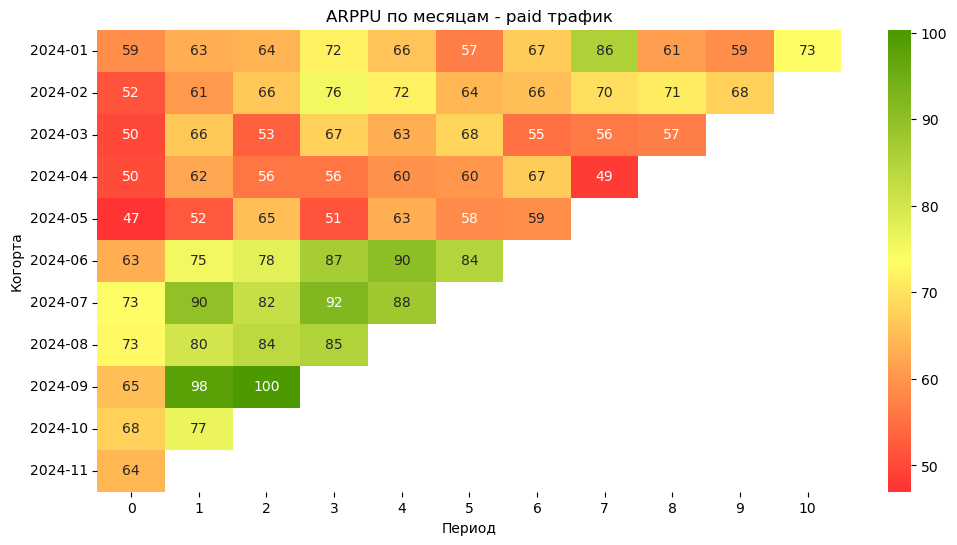

In [138]:
# Строим heatmap ARPPU с палитрой
sns.heatmap(df_pivot_arppu, cmap=cmap, annot=True, fmt='.0f')
plt.title('ARPPU по месяцам - paid трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

- Рассчитываем и визуализируем Retention Rate

In [141]:
# Создаём сводную таблицу активных пользователей из платного трафика
df_pivot_active_users = df_monthly_paid.pivot_table(
    index='first_activity_month',
    columns='n_period',
    values='device_id',
    aggfunc='nunique',
)

In [143]:
# Рассчитываем Retention Rate (%)
df_pivot_retention = df_pivot_active_users.div(df_pivot_active_users.iloc[:, 0], axis=0) * 100

In [145]:
# Создаём график
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

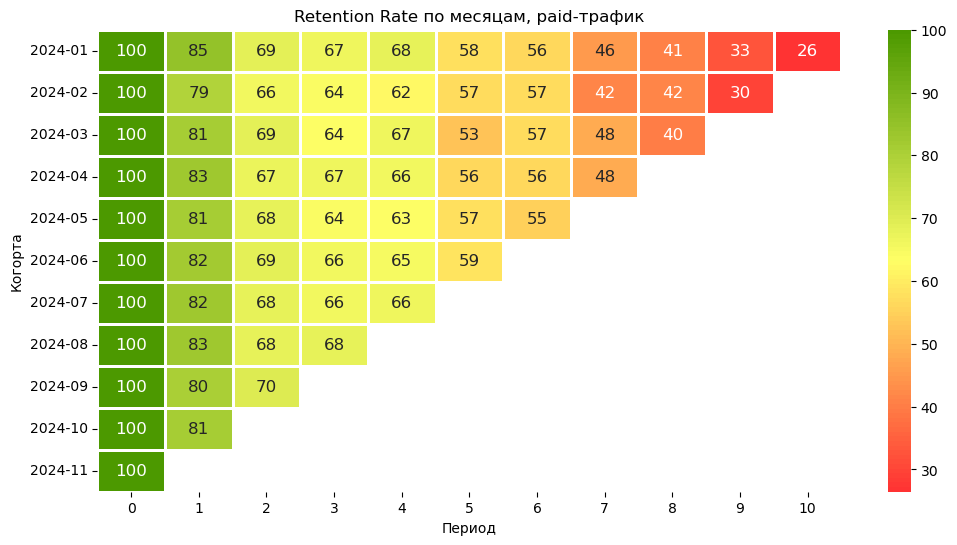

In [147]:
# Строим heatmap Retention Rate с палитрой
sns.heatmap(df_pivot_retention,
            cmap=cmap,
            annot=True,
            fmt='.0f',  
            linewidths=2,
            annot_kws={"size": 12})
plt.title('Retention Rate по месяцам, paid-трафик')
plt.xlabel('Период')
plt.ylabel('Когорта')
plt.show()

**Негативное изменение:** САС

**Практически без изменений:** Payback Period, ROI, Retention

**Положительное изменение** LTV, ARPPU

**Рекомендации бизнесу:**

Продолжить инвестиции в платный трафик, но оптимизировать таргетинг для привлечения более ценной аудитории и снижения CAC.
Стабильный ROI подтверждает текущую окупаемость, а оптимизация CAC повысит маржинальность. Рост LTV позволяет масштабироваться при условии контроля за затратами.